<a href="https://colab.research.google.com/github/bhattacharjee/msc-ai-project/blob/main/iteration_3.0.ipynb/Autoencoder_iteration_3.8_cnn_invert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
auc_scores = {}
N_EPOCHS = 50
#INVERT_TRAIN_TEST = False # If False, train with encrypted and test with non-encrypted
INVERT_TRAIN_TEST = True # If False, train with encrypted and test with non-encrypted
LOSS_FUNCTION='mse'   # mse or binary_crossentropy

RANDOM_SEED = 42

In [2]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging, sys, random, glob
from google.colab import drive
from functools import lru_cache
import sklearn
from sklearn.model_selection import train_test_split

from tensorflow import keras as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import IPython

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


drive.mount("/content/drive")

def set_random_seed():
    np.random.seed(1)
    random.seed(1)
    tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

!if [[ -d /content/drive/MyDrive/MSCPROJDATA ]]; then cp -r /content/drive/MyDrive/MSCPROJDATA .; fi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def get_columns(thisdf):
    baseline_columns = [c for c in thisdf.columns if c.startswith('baseline') and "head" not in c and "tail" not in c]
    baseline_columns = [c for c in baseline_columns if "filesize" not in c]
    baseline_columns = [c for c in baseline_columns if "begin" not in c and "end" not in c]

    advanced_columns = [c for c in thisdf.columns if "advanced" in c]
    advanced_columns = [c for c in advanced_columns if "begin" not in c and "end" not in c]
    advanced_columns = [c for c in advanced_columns if "head" not in c and "tail" not in c]
    advanced_columns = [c for c in advanced_columns if "start" not in c]
    advanced_columns_only = list(set(advanced_columns))
    advanced_columns = list(set(advanced_columns + baseline_columns))

    fourier_columns = [c for c in thisdf.columns if "fourier" in c and "value" not in c]
    fourier_columns = [c for c in fourier_columns if "1byte" in c]
    fourier_columns = [c for c in fourier_columns if "begin" not in c and "end" not in c]
    fourier_columns = [c for c in fourier_columns if "head" not in c and "tail" not in c]
    fourier_columns = [c for c in fourier_columns if "start" not in c]
    fourier_columns_only = list(set(fourier_columns))
    fourier_columns = list(set(advanced_columns + fourier_columns))
    
    baseline_and_advanced = list(set(baseline_columns + advanced_columns_only))
    baseline_and_fourier = list(set(baseline_columns + fourier_columns_only))
    advanced_and_fourier = list(set(advanced_columns_only + fourier_columns_only))

    all_columns = [c for c in thisdf.columns]
    
    return {\
        "baseline": baseline_columns,\
        "advanced-only": advanced_columns_only,\
        "fourier-only": fourier_columns_only,\
        "baseline-and-fourier": baseline_and_fourier,\
        "advanced-and-fourier": advanced_and_fourier,\
        "advanced": advanced_columns,\
        "fourier": fourier_columns,\
        "all_columns": all_columns,
        "1byte-values-only": [c for c in thisdf.columns if "1byte" in c and "value" in c],
        "4byte-values-only": [c for c in thisdf.columns if "4byte" in c and "value" in c],
        "1byte-and-4byte": [c for c in thisdf.columns if "byte" in c and "value" in c]
    }

# @lru_cache(maxsize=5)
def load_datasets_once():
    """Load all datasets only once
    
    We want to load the datasets only once. Once loaded
    serve from cache
    """
    datasets = dict()
    for file in glob.glob("MSCPROJDATA/**.parquet.gz", recursive=True):
        if not file.startswith("MSCPROJDATA/n1"):
            print(f"Loading {file}")
            df = pd.read_parquet(file)
            df = df.sample(frac=1).reset_index(drop=True)
            df["is_encrypted"] = 1 if "encr" in file.lower() else 0
            datasets[file] = df
    return datasets

tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [4]:
temp_all_dfs = load_datasets_once()
temp_all_dfs['MSCPROJDATA/plaintext.base32.combined.parquet.gz'].columns

all_column_names = get_columns(temp_all_dfs['MSCPROJDATA/plaintext.base32.combined.parquet.gz'])
print(all_column_names.keys())
temp_all_dfs = None

import gc
def gc_collect():
    [gc.collect(i) for i in range(3) for j in range(3)]

gc_collect()

Loading MSCPROJDATA/plaintext.base32.combined.parquet.gz
Loading MSCPROJDATA/plaintext.expanded.parquet.gz
Loading MSCPROJDATA/expanded.plaintext.base32.parquet.gz
Loading MSCPROJDATA/plaintext.combined.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v1.b32.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v2.base32.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v1.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v2.parquet.gz
dict_keys(['baseline', 'advanced-only', 'fourier-only', 'baseline-and-fourier', 'advanced-and-fourier', 'advanced', 'fourier', 'all_columns', '1byte-values-only', '4byte-values-only', '1byte-and-4byte'])


In [5]:
all_datasets = load_datasets_once()
full_dataset = pd.concat(all_datasets.values())
full_dataset = full_dataset.fillna(0.0)

if not INVERT_TRAIN_TEST:
    encrypted_df = full_dataset[full_dataset["is_encrypted"] == 1]
    non_encrypted_df = full_dataset[full_dataset["is_encrypted"] == 0]
else:
    encrypted_df = full_dataset[full_dataset["is_encrypted"] == 0]
    non_encrypted_df = full_dataset[full_dataset["is_encrypted"] == 1]

discard_some = True
if discard_some:
    retain = full_dataset['extended.base_filename'].map(lambda x: ".webp" not in x and "b32" not in x and "base32" not in x)
    full_dataset = full_dataset[retain]

# shuffle
encrypted_df = encrypted_df.sample(frac=1).reset_index(drop=True)
non_encrypted_df = non_encrypted_df.sample(frac=1).reset_index(drop=True)

columns = all_column_names["all_columns"]
print(f"Number of features in full dataset: {len(columns)}")

work_encrypted_df_X = encrypted_df[columns]
work_encrypted_df_y = encrypted_df["is_encrypted"]
work_non_encrypted_df_X = non_encrypted_df[columns]
work_non_encrypted_df_y = non_encrypted_df["is_encrypted"]


columns = []
for i, j in zip(work_encrypted_df_X.dtypes, work_encrypted_df_X.columns):
    if "float" in str(i):
        columns.append(j)

work_encrypted_df_X = work_encrypted_df_X[columns]
work_non_encrypted_df_X = work_non_encrypted_df_X[columns]

import gc
del all_datasets
del encrypted_df
del non_encrypted_df
for i in range(3):
    for j in range(3):
        gc.collect(j)
        gc.collect(i)

def normalize_df(X, Y):
    mindf = X.min()
    maxdf = X.max()
    print(mindf.shape)
    X = (X - mindf) / (maxdf - mindf)
    Y = (Y - mindf) / (maxdf - mindf)
    return X, Y

work_encrypted_df_X, work_non_encrypted_df_X = \
    normalize_df(
        work_encrypted_df_X,
        work_non_encrypted_df_X
    )

gc_collect()

Loading MSCPROJDATA/plaintext.base32.combined.parquet.gz
Loading MSCPROJDATA/plaintext.expanded.parquet.gz
Loading MSCPROJDATA/expanded.plaintext.base32.parquet.gz
Loading MSCPROJDATA/plaintext.combined.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v1.b32.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v2.base32.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v1.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v2.parquet.gz
Number of features in full dataset: 676
(668,)


In [6]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(\
        work_encrypted_df_X,
        work_encrypted_df_y,
        test_size=0.33,
        random_state=42)

X_train.shape

(216686, 668)

In [7]:
def print_and_plot(model):
    print(model.summary())
    plot = tf.keras.utils.plot_model(
        model,
        show_shapes=True,
        expand_nested=True)
    IPython.display.display(plot)


from sklearn.model_selection import train_test_split
def create_and_train_autoencoder(X, y, model, n_epochs):
    X_train, X_eval, y_train, y_eval= \
        train_test_split(X, y, test_size=0.2, random_state=42)

    nn = model
    nn.compile(optimizer='adam', loss=LOSS_FUNCTION, metrics=["mae", "mse"])

    nn.build((None, X.shape[1]))
    print_and_plot(nn)

    es_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=5,
        verbose=1,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )

    print(X_train.shape, X_eval.shape)
    history = nn.fit(X_train, X_train,
                epochs=n_epochs,
                validation_data=(X_eval, X_eval),
                batch_size=32,
                callbacks=[es_callback])
    return nn, history


def evaluate_model(model, columns:list, n_epochs:int, description:str):
    tf.random.set_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    c1 = set([c for c in work_encrypted_df_X.columns])
    c2 = set(columns)
    columns = c1.intersection(c2)
    print(f"Number of features: {len(columns)}")

    # Encrypted section, use half for training, we will use the remaining
    # half for testing
    temp_work_encrypted_df_X = work_encrypted_df_X[columns]
    temp_work_non_encrypted_df_X = work_non_encrypted_df_X[columns]

    nn = model

    columns = []
    for i, j in zip(temp_work_encrypted_df_X.dtypes, temp_work_encrypted_df_X.columns):
        if "float" in str(i):
            columns.append(j)
    temp_work_encrypted_df_X = temp_work_encrypted_df_X[columns]
    temp_work_non_encrypted_df_X = temp_work_non_encrypted_df_X[columns]

    eTrain_X, eTest_X, eTrain_y, eTest_y = \
        train_test_split(\
                        temp_work_encrypted_df_X,\
                        work_encrypted_df_y,\
                        test_size=0.2,\
                        random_state=42)

    nn, history = create_and_train_autoencoder(eTrain_X, eTrain_y, model, n_epochs)

    _, neTest_X, _, neTest_y = \
        train_test_split(\
                        temp_work_non_encrypted_df_X,\
                        work_non_encrypted_df_y,\
                        test_size=0.2,\
                        random_state=42)

    final_test_X = pd.concat([eTest_X, neTest_X])
    final_test_y = pd.concat([eTest_y, neTest_y])

    # ---------------------
    plt.rcParams["figure.figsize"] = (6, 3)
    
    plt.rcParams["figure.figsize"] = (12, 6)
    for metric in ["loss", "mse", "mae"]:
        keys = []
        for k, v in history.history.items():
            if metric in k.lower():
                keys.append(k)
                plt.plot(v, label=k)
            plt.legend(keys)
        plt.show()

    # ----------------------------

    plt.rcParams["figure.figsize"] = (12, 6)
    def get_mse_mae(X, X1):
        saveX, saveX1 = X, X1
        if not isinstance(X, np.ndarray):
            X = X.to_numpy()
        if not isinstance(X1, np.ndarray):
            X1 = X1.to_numpy()
        square_error = np.square(X - X1)
        mse = np.mean(square_error, axis=1)
        abs_error = np.square(X - X1)
        mae = np.mean(abs_error, axis=1)
        return mse, mae
    
    
    
    reconstructed_test_X = nn.predict(final_test_X)
    mse, mae = get_mse_mae(final_test_X, reconstructed_test_X)
    
    
    df_result = pd.DataFrame(\
        {\
            "is_encrypted": final_test_y,\
            "mse": mse,\
            "mae": mae,\
        }\
    )
    
    #df_result2 = df_result[df_result["mae"] < 0.1]

    def show_strip_plot(df_result):
        x_text = "is_encrypted"
        #if not INVERT_TRAIN_TEST:
        #    x_text = "is_encrypted"
        #else:
        #    x_text = "is_encrypted"
        df_result2 = df_result.copy()
        #if INVERT_TRAIN_TEST:
        #    df_result2.rename(columns={"is_encrypted": "is_plaintext"}, inplace=True)
        sns.stripplot(data=df_result2, x=x_text, y="mse", jitter=0.5, size=0.7).set(title="Mean Square Error")
        plt.gca().set_yscale('log')
        plt.show()
        sns.boxplot(data=df_result2, x=x_text, y="mse").set(title="Mean Square Error")
        
        plt.gca().set_yscale('log')
        plt.show()
    
    show_strip_plot(df_result)

    df = df_result
    df = df.sort_values(by="mse").reset_index()
    y_pred = np.log(df["mse"].to_numpy())
    y_true = df["is_encrypted"].to_numpy()
    
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true=y_true, y_score=y_pred)
    auc_score = auc(fpr, tpr)
    print()
    print()
    plt.plot(fpr, tpr)
    print()
    print()
    print(f"AUC Score for {description} is : {auc_score}")

    return description, auc_score

In [8]:
print(all_column_names.keys())

dict_keys(['baseline', 'advanced-only', 'fourier-only', 'baseline-and-fourier', 'advanced-and-fourier', 'advanced', 'fourier', 'all_columns', '1byte-values-only', '4byte-values-only', '1byte-and-4byte'])


Number of features: 502
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 502)               0         
                                                                 
 encoder_reshape (Reshape)   (None, 251, 2)            0         
                                                                 
 zero_padding1d (ZeroPadding  (None, 256, 2)           0         
 1D)                                                             
                                                                 
 encoder_1 (Conv1D)          (None, 256, 3)            21        
                                                                 
 spatial_dropout1d (SpatialD  (None, 256, 3)           0         
 ropout1D)                                                       
                                                                 
 max_pooling1d (MaxPooling1D  (N

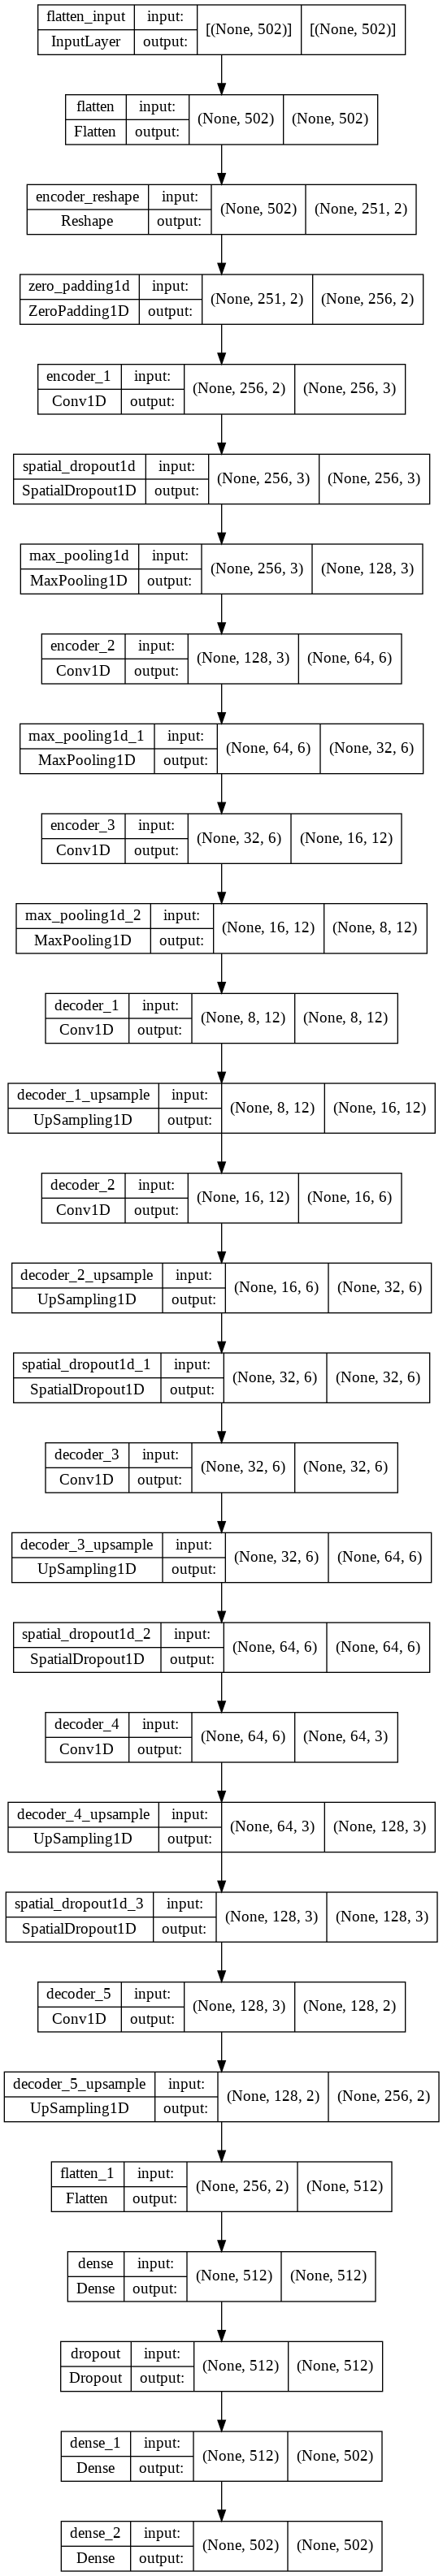

(206983, 502) (51746, 502)
Epoch 1/50
6469/6469 [==============================] - 69s 10ms/step - loss: 0.0012 - mae: 0.0117 - mse: 0.0012 - val_loss: 4.0619e-04 - val_mae: 0.0095 - val_mse: 4.0619e-04
Epoch 2/50
6469/6469 [==============================] - 61s 9ms/step - loss: 2.8721e-04 - mae: 0.0069 - mse: 2.8721e-04 - val_loss: 3.6596e-04 - val_mae: 0.0086 - val_mse: 3.6596e-04
Epoch 3/50
6469/6469 [==============================] - 62s 10ms/step - loss: 2.7715e-04 - mae: 0.0066 - mse: 2.7715e-04 - val_loss: 3.3601e-04 - val_mae: 0.0086 - val_mse: 3.3601e-04
Epoch 4/50
6469/6469 [==============================] - 61s 9ms/step - loss: 2.6535e-04 - mae: 0.0064 - mse: 2.6535e-04 - val_loss: 3.7743e-04 - val_mae: 0.0092 - val_mse: 3.7743e-04
Epoch 5/50
6469/6469 [==============================] - 61s 9ms/step - loss: 2.5978e-04 - mae: 0.0063 - mse: 2.5978e-04 - val_loss: 2.9867e-04 - val_mae: 0.0078 - val_mse: 2.9867e-04
Epoch 6/50
6469/6469 [==============================] - 63s 10ms

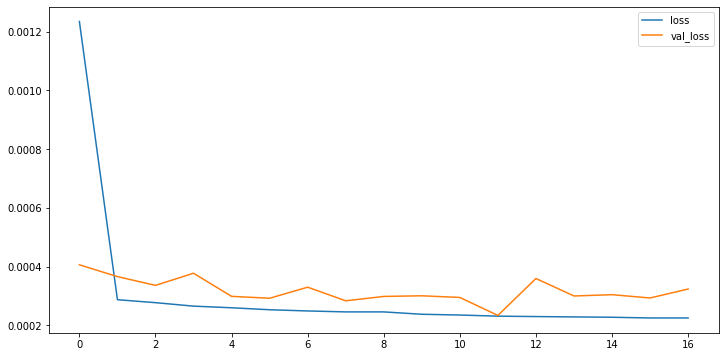

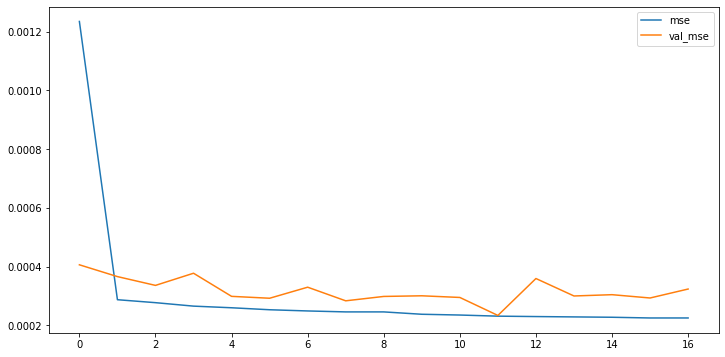

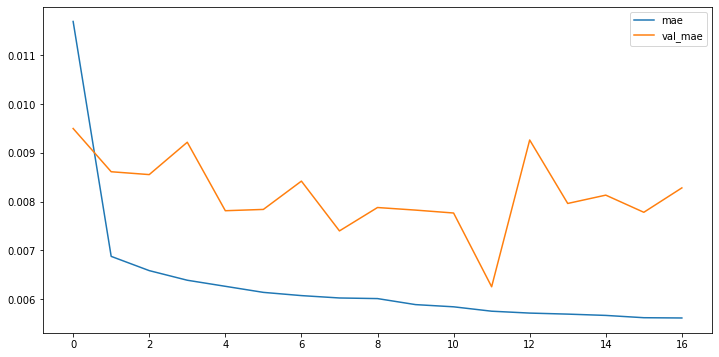

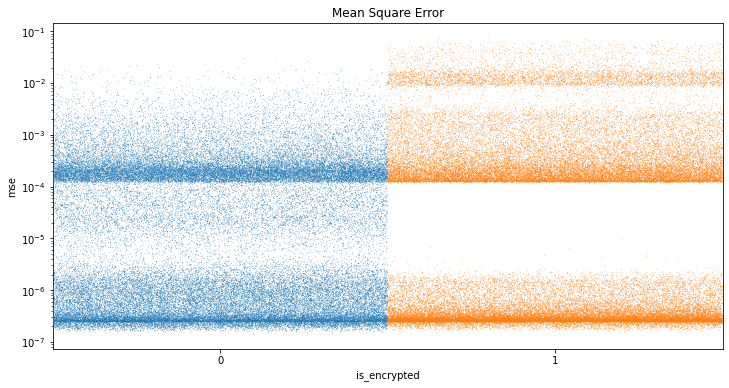

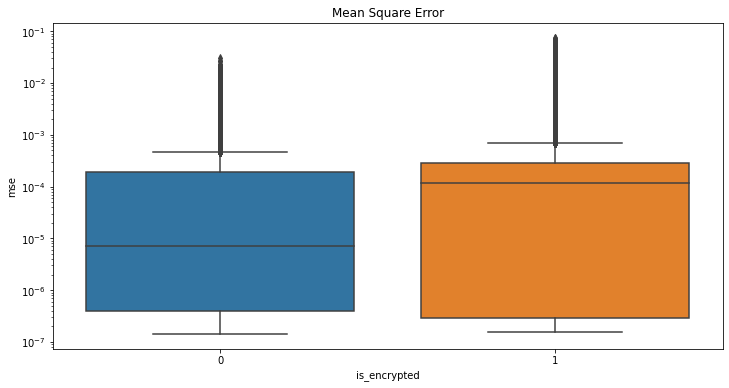





AUC Score for CNN: raw spectrum both 4-bytes and 1-byte is : 0.5140776728393954


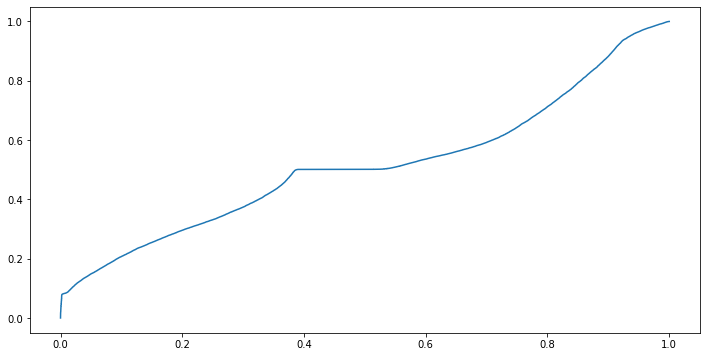

In [9]:
gc_collect()
class Autoencoder_AllColumns:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                # Encoder
                layers.Flatten(),
                layers.Reshape((251, 2), name="encoder_reshape"),
                layers.ZeroPadding1D(padding=(0, 5)),
                layers.Conv1D(3, kernel_size=3, activation='relu', name="encoder_1", padding="same"),
                layers.SpatialDropout1D(0.2),
                layers.MaxPooling1D(2),
                layers.Conv1D(6, kernel_size=3, activation='relu', strides=2, name="encoder_2", padding="same"),
                layers.MaxPooling1D(2),
                layers.Conv1D(12, kernel_size=5, activation='relu', strides=2, name="encoder_3", padding="same"),
                layers.MaxPooling1D(2),
                # Shape at this point (8, 12) where 12 is the number of channels

                # Decoder
                layers.Conv1D(12, kernel_size=5, activation='relu', strides=1, name="decoder_1", padding="same"),
                layers.UpSampling1D(2, name="decoder_1_upsample"),
                layers.Conv1D(6, kernel_size=3, activation='relu', strides=1, name="decoder_2", padding="same"),
                layers.UpSampling1D(2, name="decoder_2_upsample"),
                layers.SpatialDropout1D(0.2),
                layers.Conv1D(6, kernel_size=3, activation='relu', strides=1, name="decoder_3", padding="same"),
                layers.UpSampling1D(2, name="decoder_3_upsample"),
                layers.SpatialDropout1D(0.2),
                layers.Conv1D(3, kernel_size=3, activation='relu', strides=1, name="decoder_4", padding="same"),
                layers.UpSampling1D(2, name="decoder_4_upsample"),
                layers.SpatialDropout1D(0.2),
                layers.Conv1D(2, kernel_size=3, activation='relu', strides=1, name="decoder_5", padding="same"),
                layers.UpSampling1D(2, name="decoder_5_upsample"),
                layers.Flatten(),
                layers.Dense(512, activation="relu"),
                layers.Dropout(0.2),
                layers.Dense(502, activation="relu"),
                layers.Dense(502, activation="sigmoid"),
            ]
        )
        return model

colname = '1byte-and-4byte'
description, score = evaluate_model(Autoencoder_AllColumns.build(), all_column_names[colname], N_EPOCHS, "CNN: raw spectrum both 4-bytes and 1-byte")
auc_scores[description] = score

gc_collect()

In [10]:
keys = [k for k in auc_scores.keys()]
auc = [a for a in auc_scores.values()]

def rename_feature(x):
    out = ""
    last_char = None
    for c in x:
        if last_char is None:
            c = c.upper()
            last_char = c
        elif last_char == '-':
            c = c.upper()
            last_char = c
        elif c == '-':
            last_char = c
            c = ' '
        elif last_char == ' ':
            c = c.upper()
            last_char = c
        else:
            last_char = c
        out += c
    return out
        

df = pd.DataFrame({"Feature Set": keys, "AUC": auc}).sort_values(by="AUC", ascending=False).reset_index(drop=True)
df["Feature Set"] = df["Feature Set"].map(rename_feature)

df

,Feature Set,AUC
0,CNN: Raw Spectrum Both 4 Bytes And 1 Byte,0.514078


In [11]:


print(df.to_latex())



\begin{tabular}{llr}
\toprule
{} &                                Feature Set &       AUC \\
\midrule
0 &  CNN: Raw Spectrum Both 4 Bytes And 1 Byte &  0.514078 \\
\bottomrule
\end{tabular}



In [12]:
!nvidia-smi

Sun Mar 27 23:30:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |   4677MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------